<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Statistical machine learning - Notebook 5, version for students
**Author: Michał Ciach**  
**Date: 12.11.2021**

## Description 
In the previous class, we learnd how we can use mathematical statistics to estimate parameters on a small number of data points and, most importantly, to quantify the uncertainty of the estimation.  
This is called *quantitative inference*, because we want to get to know some quantity.  
In today's class, we'll learn a technique called *statistical hypothesis testing*.  
This is a technique to do *qualitative inference* - that is, to get to know some property of the data.  
The general idea is to set up a hypothesis - i.e. that some parameter is greater than 0 - and try to reject it by showing that our data would be very unlikely to observe if this hypothesis was true.  

In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1GW1pjKOCoKOlC4Jqbqql_ghYD_n0iC6O
!gdown https://drive.google.com/uc?id=1FInZ2jrlZGNColU4sHF9JKGHP39fTVut
!gdown https://drive.google.com/uc?id=1n1qS6dcVVKcVJOuUIIm0VTz6cSyrtzDH

Downloading...
From: https://drive.google.com/uc?id=1GW1pjKOCoKOlC4Jqbqql_ghYD_n0iC6O
To: /content/BDL municipality incomes 2015-2020.csv
100% 228k/228k [00:00<00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FInZ2jrlZGNColU4sHF9JKGHP39fTVut
To: /content/BDL municipality area km2 2015-2020.csv
100% 180k/180k [00:00<00:00, 50.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n1qS6dcVVKcVJOuUIIm0VTz6cSyrtzDH
To: /content/BDL municipality population 2015-2020.csv
100% 222k/222k [00:00<00:00, 50.0MB/s]


In [2]:
!pip install --upgrade scipy

     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Data & library imports

Run the cells below to import the required libraries and load the data for today's class.  

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import t as tstud
from scipy.stats import ttest_ind, ttest_rel, norm, kstest

In [4]:
income = pd.read_csv('BDL municipality incomes 2015-2020.csv', sep=';', dtype={'Code': 'str'})
income

,Code,Region,2015,2016,2017,2018,2019,2020
0,0201011,Bolesławiec (1),9.776646e+07,9.658595e+07,1.003549e+08,1.000265e+08,1.107985e+08,1.138563e+08
1,0201022,Bolesławiec (2),3.107224e+07,2.913815e+07,3.683091e+07,3.484836e+07,3.871533e+07,4.288890e+07
2,0201032,Gromadka (2),1.089941e+07,1.313974e+07,1.454154e+07,2.705794e+07,2.572157e+07,2.754443e+07
3,0201043,Nowogrodziec (3),1.856915e+07,2.941747e+07,3.188345e+07,3.178886e+07,3.913420e+07,3.341908e+07
4,0201052,Osiecznica (2),1.674647e+07,1.709802e+07,1.760182e+07,1.984173e+07,2.177626e+07,2.484304e+07
...,...,...,...,...,...,...,...,...
2504,3218043,Resko (3),1.523513e+07,1.448583e+07,1.611091e+07,1.763241e+07,1.760038e+07,1.941628e+07
2505,3218053,Węgorzyno (3),1.069708e+07,1.037428e+07,1.082646e+07,1.201310e+07,1.359405e+07,2.503944e+07
2506,3261011,Koszalin (1),2.697281e+08,2.891235e+08,3.054048e+08,3.245613e+08,3.432316e+08,3.840694e+08
2507,3262011,Szczecin (1),1.350327e+09,1.372046e+09,1.343422e+09,1.431826e+09,1.545381e+09,1.739014e+09


The cells below will append a column with voivodeship names to the `income` data set. We'll use this column in today's exercises.  

In [5]:
voivodeship_names = {
    '02': 'Dolnośląskie',
    '04': 'Kujawsko-pomorskie',
    '06': 'Lubelskie',
    '08': 'Lubuskie',
    '10': 'Łódzkie',
    '12': 'Małopolskie',
    '14': 'Mazowieckie',
    '16': 'Opolskie',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomorskie',
    '24': 'Śląskie',
    '26': 'Świętokrzyskie',
    '28': 'Warmińsko-mazurskie',
    '30': 'Wielkopolskie',
    '32': 'Zachodniopomorskie'
}

In [6]:
code_list = [s[:2] for s in income["Code"]]
name_list = [voivodeship_names[code] for code in code_list]
income['Voivodeship'] = name_list

## Testing the value of the mean

**Exercise 1.** In this exercise, we'll use a statistical test to check if the mean income of municipalities in Poland increased in 2020 compared to 2019 based on a sample of municipalities.  
Select the income in 2019 and 2020 and remove the missing values.  
Plot a histogram of the difference of the income and calculate its mean.  
Whether the true mean difference is greater or less than zero is our *ground truth* that we will try to establish by testing a small sample.  

Get a random sample of 20 municipalities. We will use this sample and some version of the Student's t test to check if the true mean is greater than zero. You can find all typical version of this test [in this Wikipedia article](https://en.wikipedia.org/wiki/Student%27s_t-test). 

What test should we use in this case: paired or unpaired? What should be the null and the alternative hypothesis if we want to show that the average income has increased?  

Calculate the test statistic (you can find the relevant formulas either in the the lecture or the Wikipedia article). Use the unbiased estimator of the variance (if you use numpy to calculate variance, you can get an unbiased estimator by adjusting the `ddof` parameter). Calculate the p-value using the `tstud.cdf` function (pay attention to the critical region for your hypothesis, i.e. the values of the test statistic that are considered unlikely if the null hypothesis is true). 

Compare your results to the `ttest_rel` function. Note: `ttest_rel(a, b, alternative='greater')` tests whether the mean of `a-b` is greater than zero.  

Are there any assumptions of the test that are violated? If so, how strongly and what effect could it have on the test result? 





In [10]:
## Write your code here.  
income_subset = income[['2019', '2020']]
income_subset = income_subset.dropna()
income_subset['difference'] = income_subset['2020'] - income_subset['2019']
income_subset

,2019,2020,difference
0,1.107985e+08,1.138563e+08,3.057754e+06
1,3.871533e+07,4.288890e+07,4.173570e+06
2,2.572157e+07,2.754443e+07,1.822855e+06
3,3.913420e+07,3.341908e+07,-5.715115e+06
4,2.177626e+07,2.484304e+07,3.066784e+06
...,...,...,...
2504,1.760038e+07,1.941628e+07,1.815902e+06
2505,1.359405e+07,2.503944e+07,1.144539e+07
2506,3.432316e+08,3.840694e+08,4.083774e+07
2507,1.545381e+09,1.739014e+09,1.936335e+08


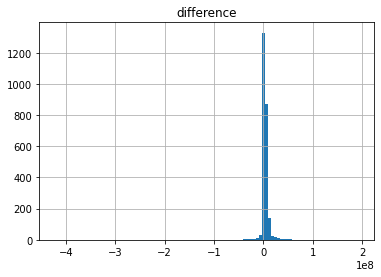

In [17]:
hist = income_subset.hist(column='difference', bins=100)

In [18]:
mean = np.mean(income_subset['difference'])
mean

3289403.9515487333

In [20]:
sample = income_subset.sample(n=20)

In [37]:
sample_mean = sample['difference'].mean()
sample_std = np.std(sample['difference'], ddof=1)
n = len(sample)

t = np.sqrt(n) * sample_mean / sample_std
t

1.7823209732840755

In [39]:
df = n - 1
1 - tstud.cdf(abs(t), df)

0.04534255462753212

In [38]:
ttest_rel(sample['2020'], sample['2019'], alternative='greater')

Ttest_relResult(statistic=1.7823209732840748, pvalue=0.04534255462753224)

**Exercise 2.** In this exercise, we will perform a statistical test to check the differences of mean incomes between voivodeships. Pick two voivodeships of your choice. Select the data for the income of municipalities from those voivodeships in 2020 using `df.loc` and `df.isin` functions, where `df` is the name of a data frame. Remove rows with missing data and add a column with log-income. Compute the means and standard deviations of income and log-income of municipalities in each voivodeship using `df.groupby` (you can find usage examples of this function on Stack Overflow). Which voivodeship has a larger mean income and log-income? Are the standard deviations similar?

Select a random sample of municipalities from each voivodeship (the two samples may have a different size). If you want to use the samples to show that voivodeship A has a higher income than voivodeship B, what should be the null and the alternative hypothesis of a statistical test? 

We will check if we can show that there is a difference in log-incomes by performing an appropriate version of the t-test. What test is appropriate here: paired or unpaired? With equal or non-equal variances? What are the advantages and disadvantages of performing the test on the log-transformed data instead of the original data?  

Regardless of the answer, compute the test statistic for the Student's t-test for unequal sizes and variances, also known as the Welsh's t-test (you can find the relevant equations [here](https://en.wikipedia.org/wiki/Student%27s_t-test) and [here](https://en.wikipedia.org/wiki/Welch%27s_t-test)). Decide yourself whether you want to use the original or the log-transformed data. Next, use the `tstud.cdf` function to calculate the p-value, paying attention to the critical region of the test. 

Compare you results to `ttest_ind` function from the `scipy` package. Pay attention to the default parameters.

Did the test show the desired result? Can you figure out why/why not?  

Use `ttest_ind` to perform a test with the assumption of equal variances. Is this assumption appropriate in your case? Did it influence the p-value? 

Perform a Welch's test using all municipalities from both voivodeships. What is the interpretation of the results? Does using a statistical test make sense in this case and why/why not? What is the consequence of this result for testing on a smaller sample?  

In [49]:
## Write your code here. 

voivodeship = ['Mazowieckie', 'Zachodniopomorskie']
voivodeship_income = income.loc[income['Voivodeship'].isin(voivodeship)]
voivodeship_income_subset = voivodeship_income[['2020', 'Voivodeship']]
voivodeship_income_subset = voivodeship_income_subset.dropna()
voivodeship_income_subset['log-income'] = np.log(voivodeship_income_subset['2020'])
voivodeship_income_subset

,2020,Voivodeship,log-income
977,2.684244e+07,Mazowieckie,17.105495
978,8.596733e+06,Mazowieckie,15.966893
979,4.726023e+06,Mazowieckie,15.368595
980,1.394005e+07,Mazowieckie,16.450277
981,1.111805e+07,Mazowieckie,16.224081
...,...,...,...
2504,1.941628e+07,Zachodniopomorskie,16.781622
2505,2.503944e+07,Zachodniopomorskie,17.035963
2506,3.840694e+08,Zachodniopomorskie,19.766334
2507,1.739014e+09,Zachodniopomorskie,21.276584


In [50]:
voivodeship_income_subset.groupby('Voivodeship').agg({'log-income': ['mean', 'std']})

log-income          
                         mean       std
Voivodeship                            
Mazowieckie         16.705422  1.077915
Zachodniopomorskie  16.950816  0.976427

In [51]:
n = 30
m = 10

mazowieckie_sample = voivodeship_income_subset[voivodeship_income_subset['Voivodeship']=='Mazowieckie'].sample(n)
zachodniopomorskie_sample = voivodeship_income_subset[voivodeship_income_subset['Voivodeship']=='Zachodniopomorskie'].sample(m)
mean_mazowieckie = mazowieckie_sample['log-income'].mean()
mean_zachodniopomorskie = zachodniopomorskie_sample['log-income'].mean()
var_mazowieckie = mazowieckie_sample['log-income'].var()
var_zachodniopomorskie = zachodniopomorskie_sample['log-income'].var()
t = (mean_mazowieckie - mean_zachodniopomorskie) / np.sqrt(var_mazowieckie / n + var_zachodniopomorskie / m)
t

-0.2704539373919977

In [57]:
df = n + m - 2
2 * (1 - tstud.cdf(abs(t), df))

0.7882746031667067

In [54]:
ttest_ind(mazowieckie_sample['log-income'], zachodniopomorskie_sample['log-income'], equal_var=False)

Ttest_indResult(statistic=-0.27045393739199763, pvalue=0.7896890874599274)

In [58]:
ttest_ind(mazowieckie_sample['log-income'], zachodniopomorskie_sample['log-income'], equal_var=True)

Ttest_indResult(statistic=-0.24129870601052625, pvalue=0.8106209347741544)

In [59]:
mazowieckie_sample = voivodeship_income_subset[voivodeship_income_subset['Voivodeship']=='Mazowieckie']
zachodniopomorskie_sample = voivodeship_income_subset[voivodeship_income_subset['Voivodeship']=='Zachodniopomorskie']
mean_mazowieckie = mazowieckie_sample['log-income'].mean()
mean_zachodniopomorskie = zachodniopomorskie_sample['log-income'].mean()
var_mazowieckie = mazowieckie_sample['log-income'].var()
var_zachodniopomorskie = zachodniopomorskie_sample['log-income'].var()
t = (mean_mazowieckie - mean_zachodniopomorskie) / np.sqrt(var_mazowieckie / len(mazowieckie_sample) + var_zachodniopomorskie / len(zachodniopomorskie_sample))
t

-2.227394650456734

In [60]:
df = len(mazowieckie_sample) + len(zachodniopomorskie_sample) - 2
2 * (1 - tstud.cdf(abs(t), df))

0.0264438795866051

**Exercise 3 - homework.** Perform the Welsh's test on the data from Exercise 1 (i.e. ignore the pairing of the variables). Compare the results and explain any differences.  

In [62]:
mean_2019 = income_subset['2019'].mean()
mean_2020 = income_subset['2020'].mean()
var_2019 = income_subset['2019'].var()
var_2020 = income_subset['2020'].var()
t = (mean_2019 - mean_2020) / np.sqrt(var_2019 / len(income_subset['2019']) + var_2020 / len(income_subset['2020']))
t

-0.38030349095832194

In [65]:
df = len(income_subset['2019']) + len(income_subset['2020']) - 2
2 * (1 - tstud.cdf(abs(t), df))

0.703736481696819

## Testing the distribution of the data

**Exercise 4.** Use the `norm.rvs` function from the `scipy` library to simulate two independent samples, each with 20 observations from the standard normal distribution. Perform the Welsh's t-test for the equality of means of those samples. Are the assumptions of Welsch's test satisfied in this case? Is the null hypothesis true? 

Repeat the procedure 5000 times to get 5000 p-values and plot them on a histogram. What is the distribution of p-values? What are the consequences of such distribution?  

Perform a [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test to verify your guess about the distribution. Use the `kstest` function from the `scipy` library (note that, in this function, you can use the name of the distribution that you want to check).  
Did the test confirm you assumption? Warning, this is a tricky question! Pay attention to the null hypothesis of this test.  

In [79]:
## Write your code here. 
sample_1 = norm.rvs(size=20)
sample_2 = norm.rvs(size=20)

mean_sample_1 = sample_1.mean()
mean_sample_2 = sample_2.mean()
var_sample_1 = sample_1.var()
var_sample_2 = sample_2.var()
t = (mean_sample_1 - mean_sample_2) / np.sqrt(var_sample_1 / len(sample_1) + var_sample_2 / len(sample_2))
t

0.78022633469296

In [80]:
df = len(sample_1) + len(sample_2) - 2
2 * (1 - tstud.cdf(abs(t), df))

0.4400908059700279

In [89]:
def welsh_ttest(sample1, sample2):
  mean_sample1, var_sample1, n1 = sample1.mean(), sample1.var(), len(sample1)
  mean_sample2, var_sample2, n2 = sample2.mean(), sample2.var(), len(sample2)

  t = (mean_sample1 - mean_sample_2) / np.sqrt(var_sample1 / n1 + var_sample2 / n2)
  df = n1 + n2 - 2
  p_val = 2 * (1 - tstud.cdf(abs(t), df))
  p_val_2 = ttest_ind(sample1, sample2, equal_var=True).pvalue
  return p_val, p_val_2

In [93]:
p_vals = []
ind = []

for _ in range(5000):
  sample_1 = norm.rvs(size=20)
  sample_2 = norm.rvs(size=20)
  p_1, p_2 = welsh_ttest(sample_1, sample_2)
  p_vals.append(p_1)
  ind.append(p_2)

In [73]:
import matplotlib.pyplot as plt

(array([53., 67., 73., 74., 91., 85., 75., 84., 80., 89., 84., 65., 60.,
        82., 76., 65., 68., 85., 74., 62., 63., 74., 75., 65., 76., 65.,
        50., 49., 66., 65., 65., 72., 50., 62., 46., 60., 47., 55., 57.,
        49., 61., 53., 33., 66., 44., 38., 46., 40., 46., 50., 41., 41.,
        54., 39., 37., 37., 42., 40., 41., 43., 34., 34., 34., 41., 35.,
        41., 23., 39., 46., 41., 35., 42., 45., 37., 32., 35., 35., 35.,
        35., 32., 52., 36., 34., 26., 32., 32., 32., 35., 33., 38., 33.,
        28., 31., 36., 29., 31., 43., 27., 33., 33.]),
 array([1.76721755e-04, 1.01734879e-02, 2.01702540e-02, 3.01670201e-02,
        4.01637863e-02, 5.01605524e-02, 6.01573185e-02, 7.01540846e-02,
        8.01508508e-02, 9.01476169e-02, 1.00144383e-01, 1.10141149e-01,
        1.20137915e-01, 1.30134681e-01, 1.40131448e-01, 1.50128214e-01,
        1.60124980e-01, 1.70121746e-01, 1.80118512e-01, 1.90115278e-01,
        2.00112044e-01, 2.10108810e-01, 2.20105577e-01, 2.30102343e-01,
  

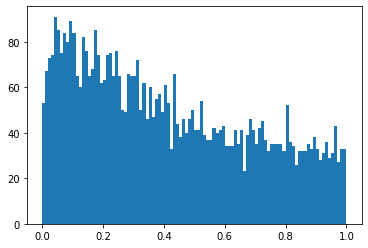

In [94]:
plt.hist(p_vals, bins=100)

(array([56., 49., 51., 60., 35., 62., 52., 52., 54., 43., 59., 48., 50.,
        51., 53., 58., 54., 54., 47., 48., 43., 48., 37., 42., 41., 50.,
        45., 49., 47., 53., 65., 41., 47., 49., 58., 60., 46., 42., 48.,
        51., 39., 49., 52., 57., 52., 47., 52., 50., 49., 50., 41., 42.,
        44., 49., 48., 49., 48., 42., 43., 48., 48., 70., 49., 44., 46.,
        52., 43., 52., 58., 43., 61., 44., 50., 51., 64., 51., 53., 60.,
        55., 43., 59., 50., 52., 49., 46., 55., 36., 35., 48., 57., 59.,
        49., 51., 62., 56., 45., 48., 66., 48., 43.]),
 array([3.22118022e-05, 1.00280183e-02, 2.00238248e-02, 3.00196313e-02,
        4.00154378e-02, 5.00112443e-02, 6.00070508e-02, 7.00028573e-02,
        7.99986637e-02, 8.99944702e-02, 9.99902767e-02, 1.09986083e-01,
        1.19981890e-01, 1.29977696e-01, 1.39973503e-01, 1.49969309e-01,
        1.59965116e-01, 1.69960922e-01, 1.79956729e-01, 1.89952535e-01,
        1.99948342e-01, 2.09944148e-01, 2.19939955e-01, 2.29935761e-01,
  

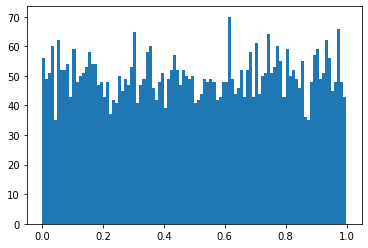

In [95]:
plt.hist(ind, bins=100)

In [97]:
kstest(p_vals, 'norm')

KstestResult(statistic=0.5000705017795278, pvalue=0.0)

In [98]:
kstest(ind, 'norm')

KstestResult(statistic=0.5000260393111068, pvalue=0.0)

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>